Obtain the polynomial fit to  the GAIA-EDR3 -> DECam transformations

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio

import healpy as hp

sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
from match_coord import match_coord

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
# The Gaia photometry in the catalog is from EDR3
cat = Table.read('/Users/rongpu/Downloads/dr10_i_band_photom_gaia_edr3-trim.fits')

In [4]:
mask = (cat['PHOT_G_MEAN_MAG']!=0) & (cat['PHOT_BP_MEAN_MAG']!=0) & (cat['PHOT_RP_MEAN_MAG']!=0)
print(np.sum(~mask), np.sum(~mask)/len(mask))
cat = cat[mask]

88 0.0001042109513867754


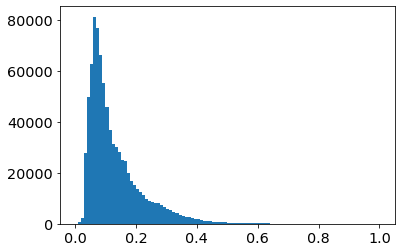

In [5]:
plt.hist(cat['ebv'], 100, range=(0, 1));

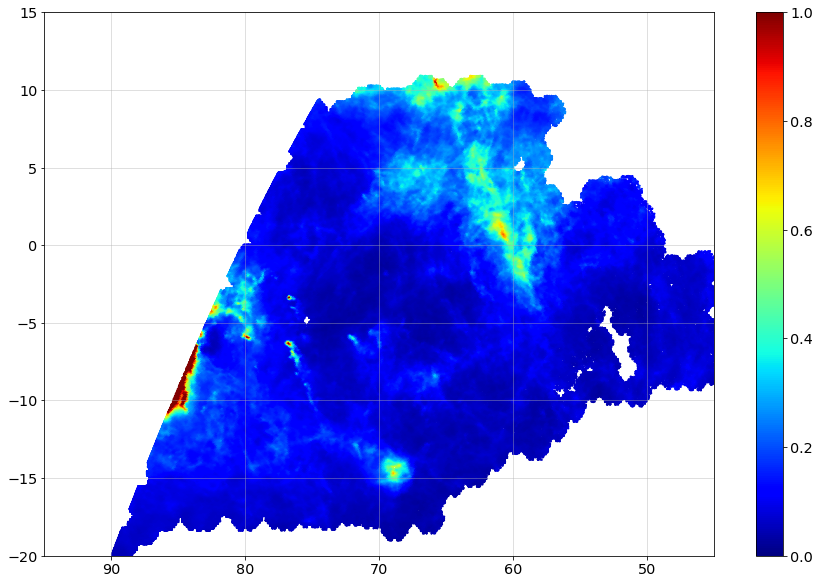

In [6]:
plt.figure(figsize=(15, 10))
plt.scatter(cat['ra'], cat['dec'], c=cat['ebv'], cmap='jet', s=1, alpha=1, vmin=0, vmax=1)
plt.grid(alpha=0.5)
plt.axis([95, 45, -20, 15])
plt.colorbar()
plt.show()

In [7]:
mask = cat['ebv']<0.15
print(np.sum(mask)/len(mask))
cat = cat[mask]

0.704370091655978


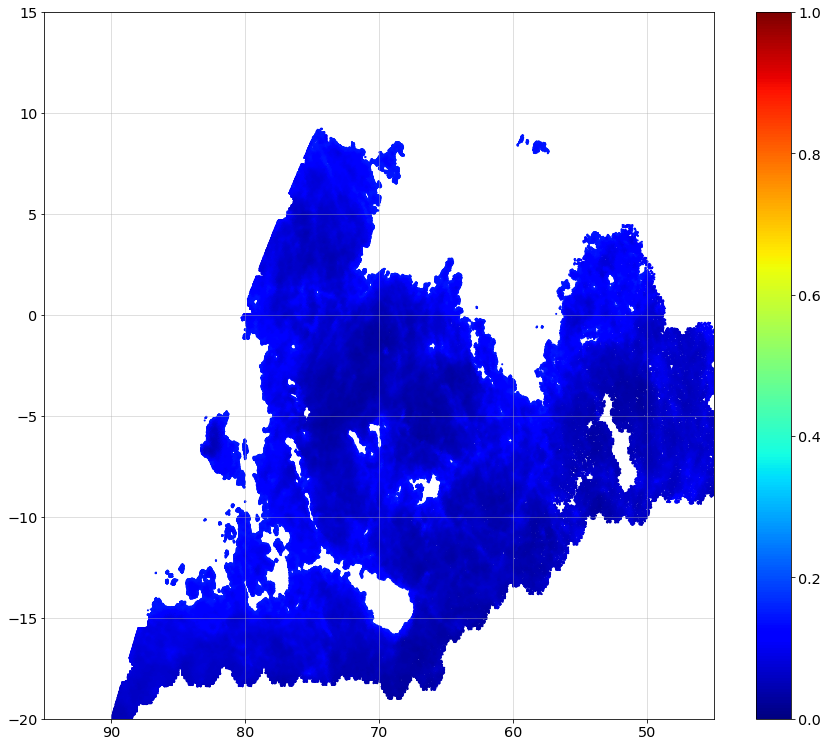

In [8]:
plt.figure(figsize=(15, 13))
plt.scatter(cat['ra'], cat['dec'], c=cat['ebv'], cmap='jet', s=1, alpha=1, vmin=0, vmax=1)
plt.grid(alpha=0.5)
plt.axis([95, 45, -20, 15])
plt.colorbar()
plt.show()

__New polynomial fits__

In [9]:
import statsmodels.api as sm

def rlm_fit1d(x, y, t=1.5, order=1):
    '''
    1D robust polynomial fit.
    
    Given x array and y array, calculate the 1D robust 
    polynomial fit of arbitrary order. Huber weight
    function is used. 
    
    See also poly_val1d.py
    
    INPUT:
    1D arrays of x and y values; tunning parameter t; 
    order of the polynomial fit.
    
    OUTPUT:
    Array of parameters of the polynomial [a0, a1, a2 ...] 
    so that y = a0 + a1*x + a2*x**2 + ...
    '''
    
    ncols = order+1
    a = np.zeros((x.size,ncols))
    for i in range(order+1):
        a[:,i] = x**i
    res = sm.RLM(y, a, M=sm.robust.norms.HuberT(t=t)).fit()
    m = res.params
    return(m)

In [10]:
poly_order = 12
band = 'i'
coeffs = {}

mask = np.ones(len(cat), dtype=bool)
x = (cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG'])[mask]
y = (cat['psfmag']-cat['PHOT_G_MEAN_MAG'])[mask]
coeffs[band] = rlm_fit1d(x, y, t=0.1, order=poly_order)
# coeffs[band] = np.polyfit(x, y, deg=2)
print(band)
print(coeffs[band])

i
[ 3.64049206e-01 -6.92975958e-01 -2.02318401e-01  2.49356147e-01
  5.35548157e-01 -1.15581285e+00  1.00443207e+00 -5.23031396e-01
  1.81825096e-01 -4.30738610e-02  6.68071214e-03 -6.07568149e-04
  2.43675699e-05]


In [11]:
np.set_printoptions(precision=5)
float_formatter = "{:.10f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [12]:
coeffs

{'i': array([0.3640492059, -0.6929759581, -0.2023184009, 0.2493561466,
        0.5355481573, -1.1558128524, 1.0044320694, -0.5230313961,
        0.1818250964, -0.0430738610, 0.0066807121, -0.0006075681,
        0.0000243676])}

In [13]:
coeffs = dict(
    i = [0.3640492059, -0.6929759581, -0.2023184009, 0.2493561466,
        0.5355481573, -1.1558128524, 1.0044320694, -0.5230313961,
        0.1818250964, -0.0430738610, 0.0066807121, -0.0006075681,
        0.0000243676],)

In [14]:
gaia_plot = Table()
gaia_plot['BP_RP'] = np.linspace(-1, 6.2, 200)
bands = ['i']

for i, b in enumerate(bands):
    mag = np.zeros(len(gaia_plot))
    for order, c in enumerate(coeffs[b]):
        mag += c * gaia_plot['BP_RP']**order
    gaia_plot['ls_'+b] = mag
    
for i, b in enumerate(bands):
    mag = np.copy(cat['PHOT_G_MEAN_MAG'])
    for order, c in enumerate(coeffs[b]):
        mag += c * (cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG'])**order
    cat[b+'mag_predict'] = mag

In [15]:
bprp_min, bprp_max = -0.6, 4.1

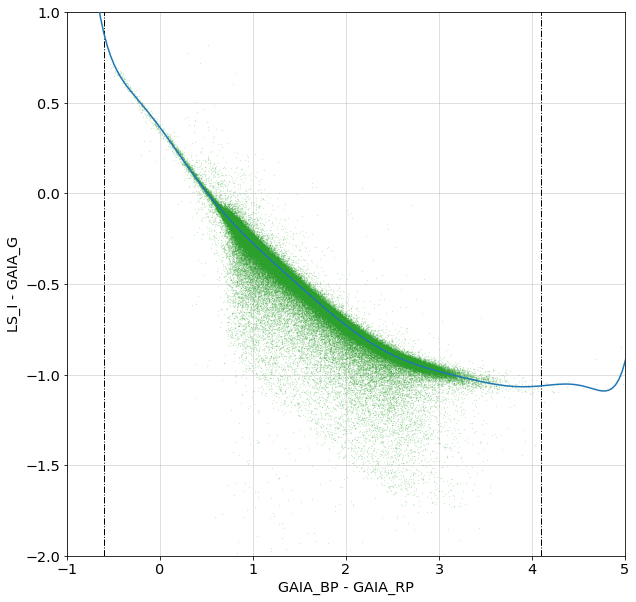

In [18]:
mask = np.ones(len(cat), dtype=bool)

plt.figure(figsize=(10, 10))
plt.plot((cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG'])[mask], (cat['psfmag']-cat['PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
plt.plot((gaia_plot['BP_RP']), (gaia_plot['ls_i']), '-', label='new transformation', zorder=3, c='C0')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('LS_I - GAIA_G')
plt.axis([-1., 5., -2, 1.])
# plt.legend(loc='upper left')
plt.grid(alpha=0.5)
# plt.savefig('plots/decals_z.png')
plt.show()

In [19]:
from scipy import stats

nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
error_of_the_mean = lambda x: nmad(x)/np.sqrt(len(x))

def binned_median(x, y, nbins=50):
    vmin, vmax = np.percentile(x, [0.1, 99.9])
    bins = np.linspace(vmin, vmax, nbins)
    bin_median, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='median', bins=bins)
    bin_error, _, _ = stats.binned_statistic(x, y, statistic=error_of_the_mean, bins=bins)    
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_median, bin_error

def binned_std(x, y, nbins=50):
    vmin, vmax = np.percentile(x, [0.1, 99.9])
    bins = np.linspace(vmin, vmax, nbins)
    bin_std, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='std', bins=bins)
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_std

def binned_nmad(x, y, nbins=50):
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    vmin, vmax = np.percentile(x, [0.1, 99.9])
    bins = np.linspace(vmin, vmax, nbins)
    bin_nmad, bin_edges, binnumber = stats.binned_statistic(x, y, statistic=nmad, bins=bins)
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_nmad

RMS 0.06259807
NMAD 0.011339618682861327


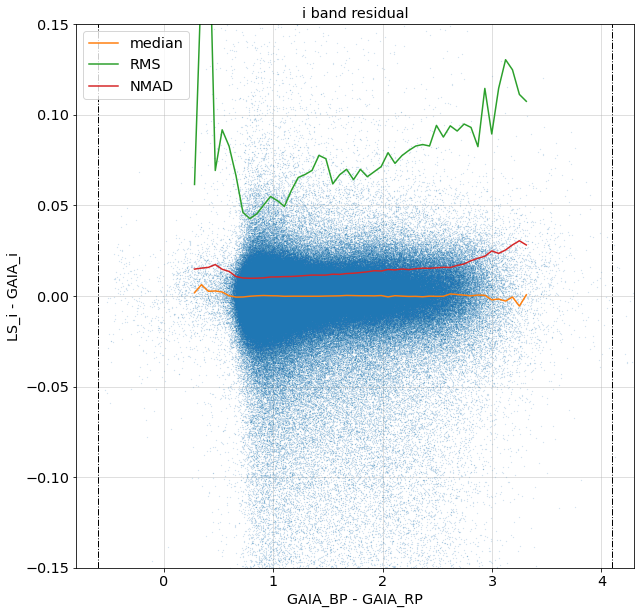

In [22]:
band = 'i'
x = cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG']
y_tractor = cat['psfmag']
y_predict = cat[band+'mag_predict']

print('RMS', np.std(y_tractor-y_predict))    
print('NMAD', nmad(y_tractor-y_predict))

bin_center, bin_edges, bin_median, bin_error = binned_median(x, y_tractor-y_predict)
bin_center, bin_edges, bin_std = binned_std(x, y_tractor-y_predict)
bin_center, bin_edges, bin_nmad = binned_nmad(x, y_tractor-y_predict)

plt.figure(figsize=(10, 10))
plt.plot(x, y_tractor-y_predict, '.', ms=0.3, alpha=0.5, zorder=2)
plt.plot(bin_center, bin_median, label='median')
plt.plot(bin_center, bin_std, label='RMS')
plt.plot(bin_center, bin_nmad, label='NMAD')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('LS_{0} - GAIA_{0}'.format(band))
plt.title('{} band residual'.format(band))
plt.axis([bprp_min-0.2, bprp_max+0.2, -0.15, 0.15])
plt.grid(alpha=0.5)
plt.legend(markerscale=10, loc='upper left')
# plt.savefig('plots/decals_{}_residual.png'.format(band))
plt.show()

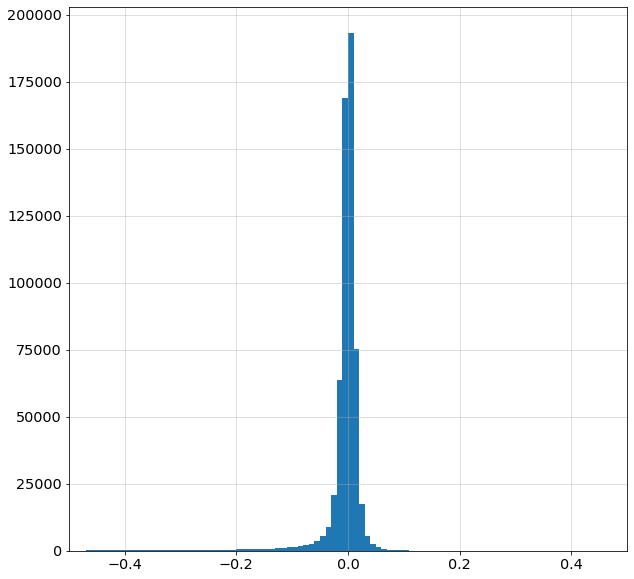

In [23]:
plt.figure(figsize=(10, 10))
plt.hist(y_tractor-y_predict, 100, range=(-0.5, 0.5))
plt.grid(alpha=0.5)
plt.xlim(-0.5, 0.5)
plt.show()